## Get a simple data set object together

In [20]:
import tensorflow as tf
from keras.layers import Conv2D, LeakyReLU, Input, MaxPooling2D, Activation, Conv2DTranspose, Concatenate, Dropout
from keras.models import Model, Sequential
import keras
import matplotlib.pyplot as plt

In [22]:
#Make the dataset
from cycleganstyletransfer.config import DATA_DIR
data_dir = DATA_DIR / "raw"


my_monet_ds_train, my_monet_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Monet",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_image_ds_train, my_image_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Images",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_monet_ds_train = my_monet_ds_train.map(lambda x: (x / 127.5) - 1)
my_image_ds_train = my_image_ds_train.map(lambda x: (x / 127.5) - 1)
    
DATASET_HEIGHT = max(len(my_monet_ds_train), len(my_image_ds_train))

my_monet_ds_train = iter(my_monet_ds_train.shuffle(42).repeat())
my_image_ds_train = iter(my_image_ds_train.shuffle(42).repeat())

Found 1193 files belonging to 1 classes.
Using 955 files for training.
Using 238 files for validation.
Found 7037 files belonging to 1 classes.
Using 5630 files for training.
Using 1407 files for validation.


## Put the Discrim model together (With regularization)

In [23]:
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    
    # First layer doesn't use instance normalization
    x = Conv2D(16, 3,padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(32, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(1, 3, padding='same')(x)
    
    return Model(inputs, x, name='discriminator')

my_discriminator = build_discriminator()
my_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 dropout_8 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 32)        4640      
                                                     

## Generator model

In [24]:
class InstanceNormalization(keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # One scale and bias per channel
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute mean and variance per instance, per channel
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super().get_config().copy()
        config.update({"epsilon": self.epsilon})
        return config


In [25]:
def DownSampleBlock(filters:int, kernel_size:int, strides:int):
    ret_block = Sequential()
    ret_block.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))
    ret_block.add(InstanceNormalization())
    ret_block.add(Activation('relu'))
    return ret_block


In [26]:
import uuid

def UpSampleBlock(filters:int, kernel_size:int, strides:int):
    ret_block = Sequential(name=f'UpsampleBlock_{uuid.uuid4()}')
    ret_block.add(Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))
    ret_block.add(InstanceNormalization())
    ret_block.add(Activation('relu'))
    return ret_block

In [27]:

def Generator(input_shape:tuple, kernel_size:int=3, strides:int=1
              ,filter_line:list[int]=[32,64,128]) -> keras.Model:
    networks_appending = []
    input_block = Input(shape=input_shape)
    ret_block = input_block

    #Create encoder chain
    for filter_choice in filter_line:
        ret_block=DownSampleBlock(filter_choice,3,2)(ret_block)
        networks_appending.append(ret_block)

    #Decoder with residual connections
    for filter_choice, network_append in zip(filter_line[::-1][1:], networks_appending[::-1][1:]):
        ret_block = UpSampleBlock(filter_choice, 3,2)(ret_block)
        ret_block = Concatenate()([ret_block, network_append])
    
    ret_block = Conv2DTranspose(input_shape[-1], kernel_size, strides, padding='same', activation='tanh')(ret_block)

    return Model(input_block, ret_block)



In [28]:
my_generator = Generator((128, 128, 3), strides=2)
my_generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 64, 64, 32)           960       ['input_9[0][0]']             
                                                                                                  
 sequential_10 (Sequential)  (None, 32, 32, 64)           18624     ['sequential_9[0][0]']        
                                                                                                  
 sequential_11 (Sequential)  (None, 16, 16, 128)          74112     ['sequential_10[0][0]']       
                                                                                            

In [29]:
def my_square_loss(y_true, y_pred):
    y_true = tf.reshape(tf.cast(y_true, tf.float32), (-1, 1, 1, 1))
    y_true = tf.broadcast_to(y_true, tf.shape(y_pred))
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))


## Introducing Generator loss

In [30]:
def generator_loss(descrim_output):
        return tf.reduce_mean(tf.math.squared_difference(tf.ones_like(descrim_output), descrim_output))

## Adding Alternating trainin


Epoch 1/8


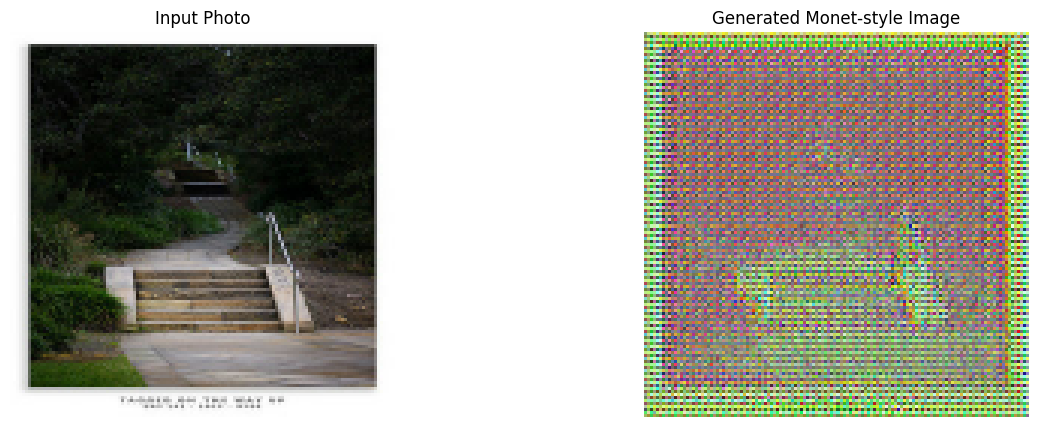

Step 1000/5630 - discriminator loss: 0.3548, generator loss: 0.2086

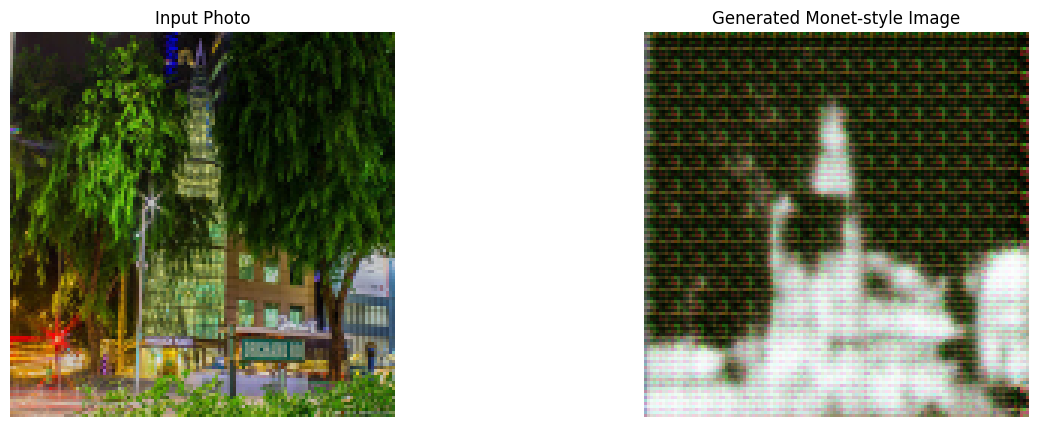

Step 2000/5630 - discriminator loss: 0.3022, generator loss: 0.2414

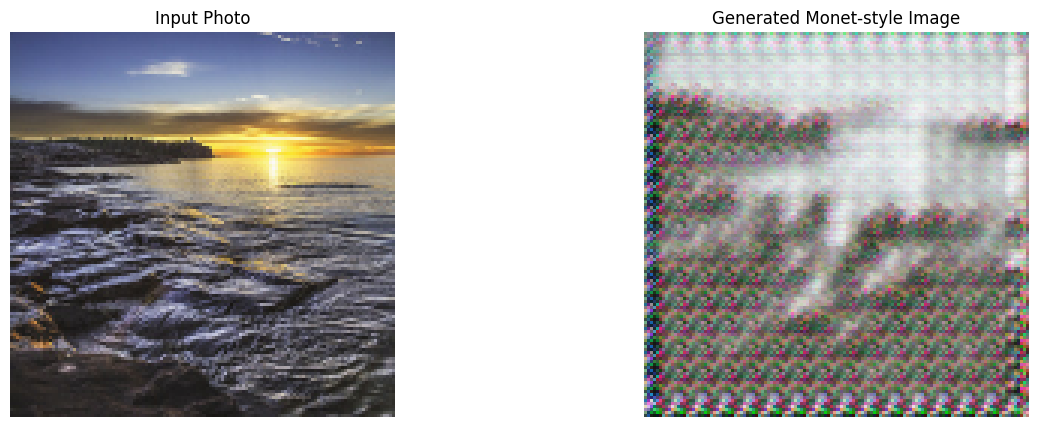

Step 3000/5630 - discriminator loss: 0.2838, generator loss: 0.2459

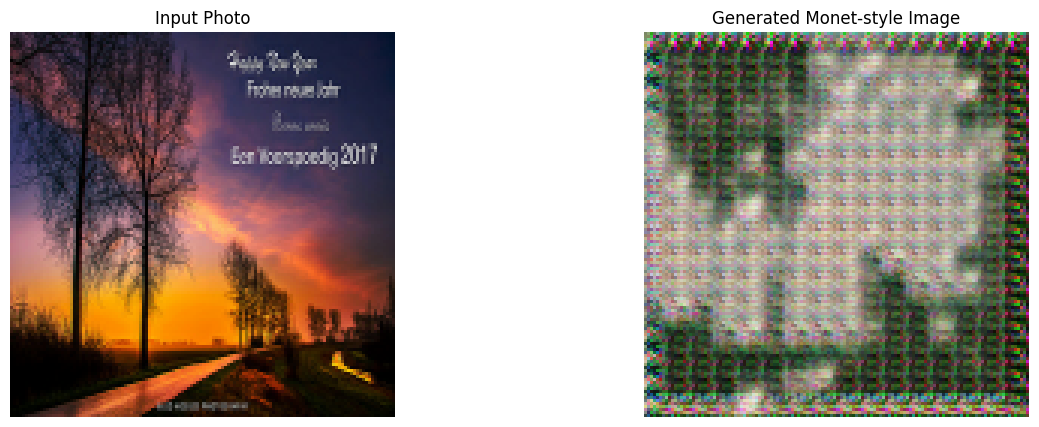

Step 4000/5630 - discriminator loss: 0.2842, generator loss: 0.2330

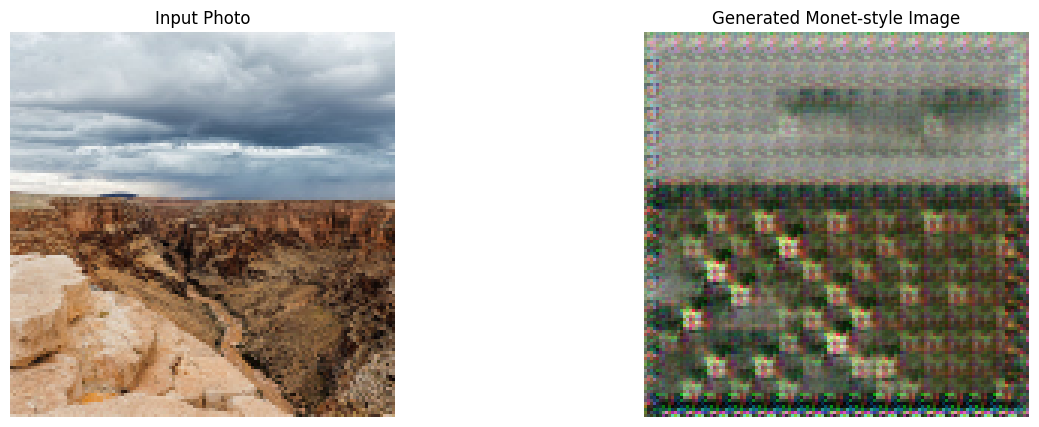

Step 5000/5630 - discriminator loss: 0.2561, generator loss: 0.2795

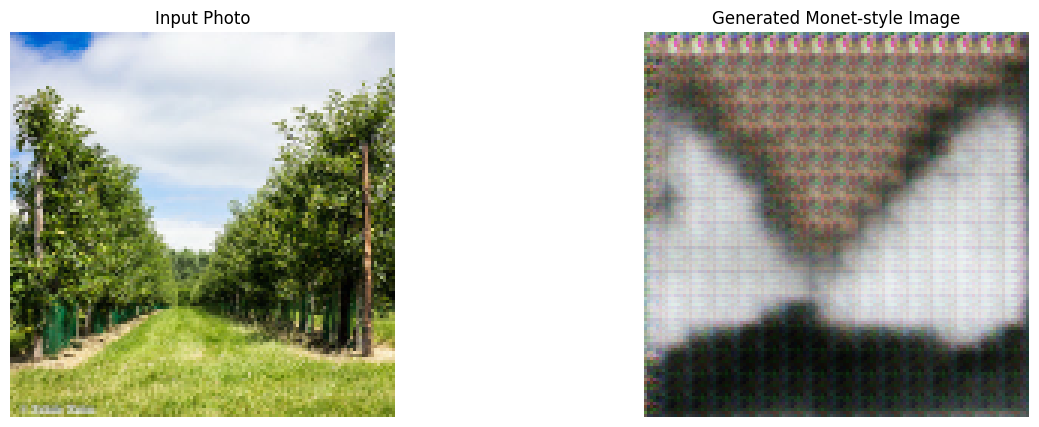

Step 5630/5630 - discriminator loss: 0.2587, generator loss: 0.2393
Epoch 1 completed in 1216s - avg discriminator loss: 0.2904, avg generator loss: 0.3177

Epoch 2/8


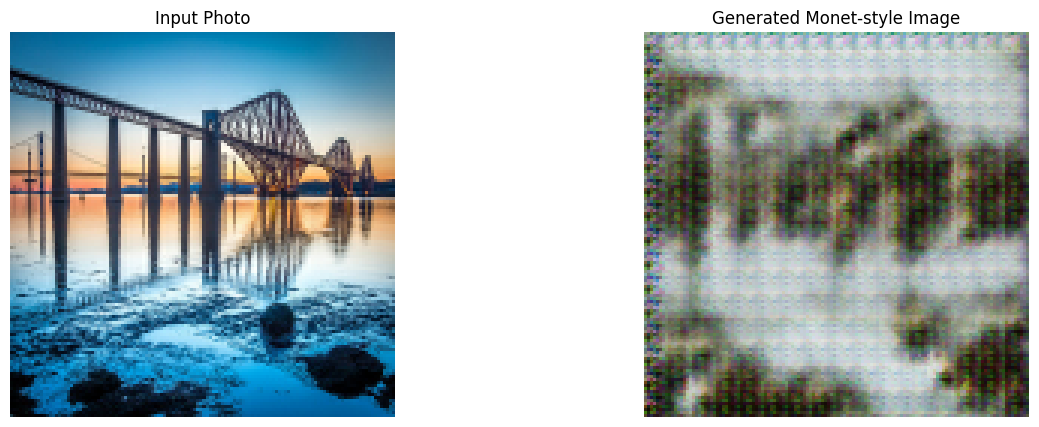

Step 1000/5630 - discriminator loss: 0.2905, generator loss: 0.2908

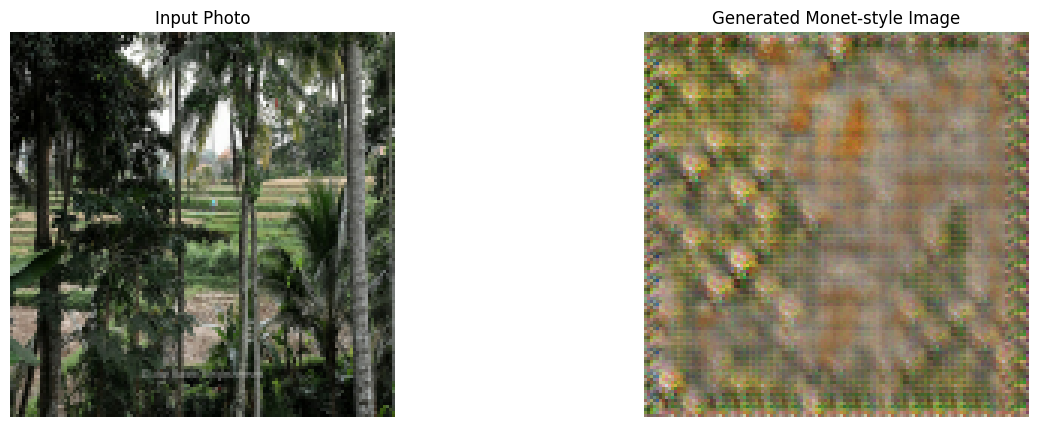

Step 2000/5630 - discriminator loss: 0.2539, generator loss: 0.2446

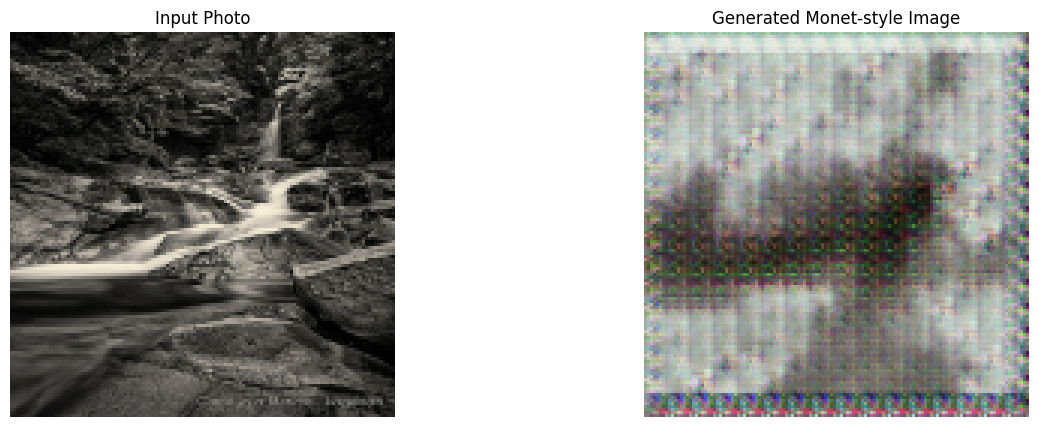

Step 3000/5630 - discriminator loss: 0.2639, generator loss: 0.2616

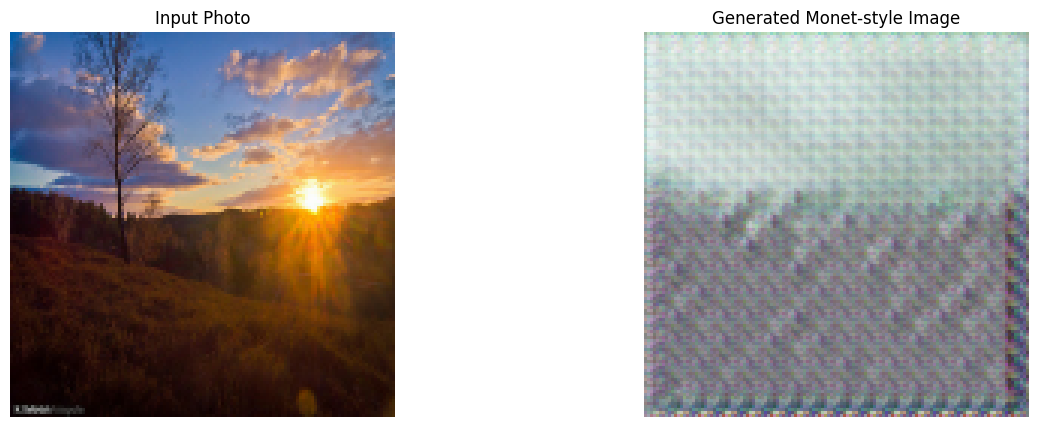

Step 4000/5630 - discriminator loss: 0.2484, generator loss: 0.2194

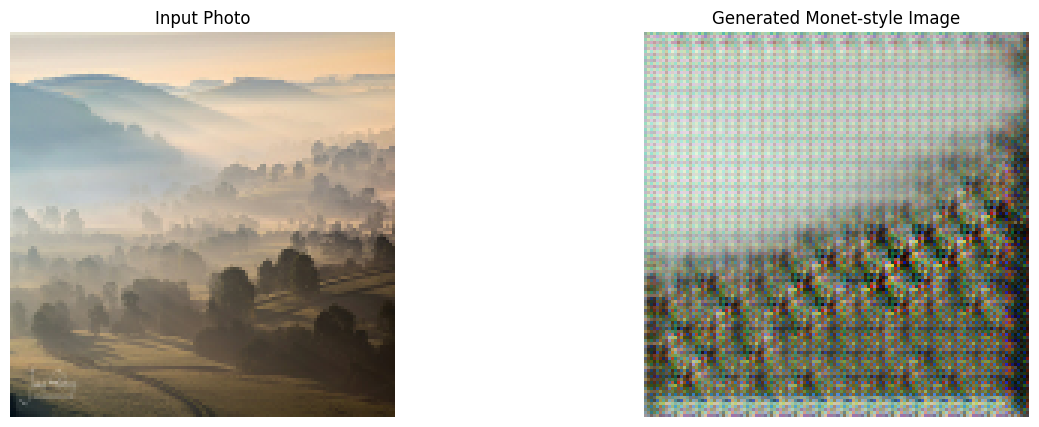

Step 5000/5630 - discriminator loss: 0.2568, generator loss: 0.2471

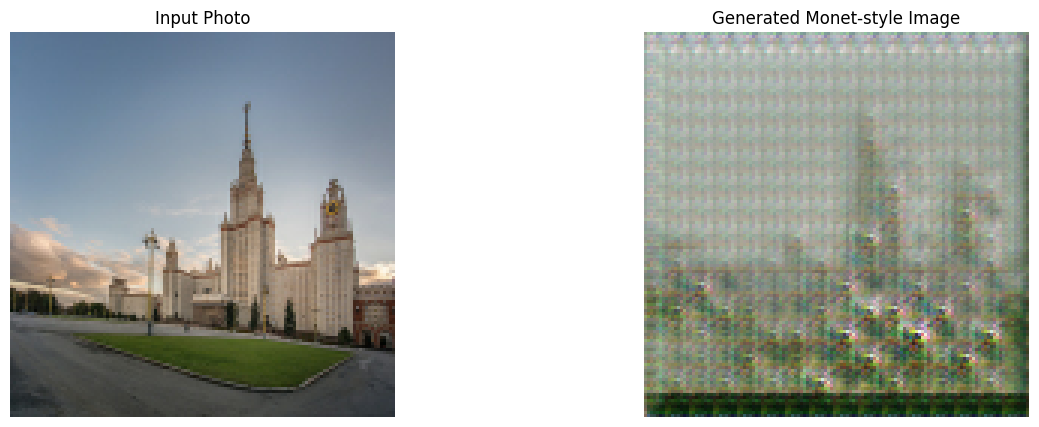

Step 5630/5630 - discriminator loss: 0.2520, generator loss: 0.2605
Epoch 2 completed in 2092s - avg discriminator loss: 0.2571, avg generator loss: 0.2534

Epoch 3/8


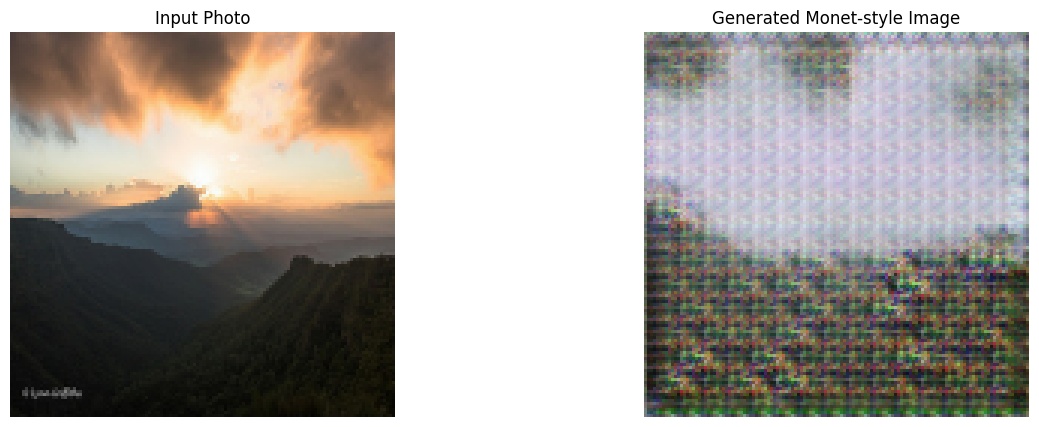

Step 1000/5630 - discriminator loss: 0.2550, generator loss: 0.2476

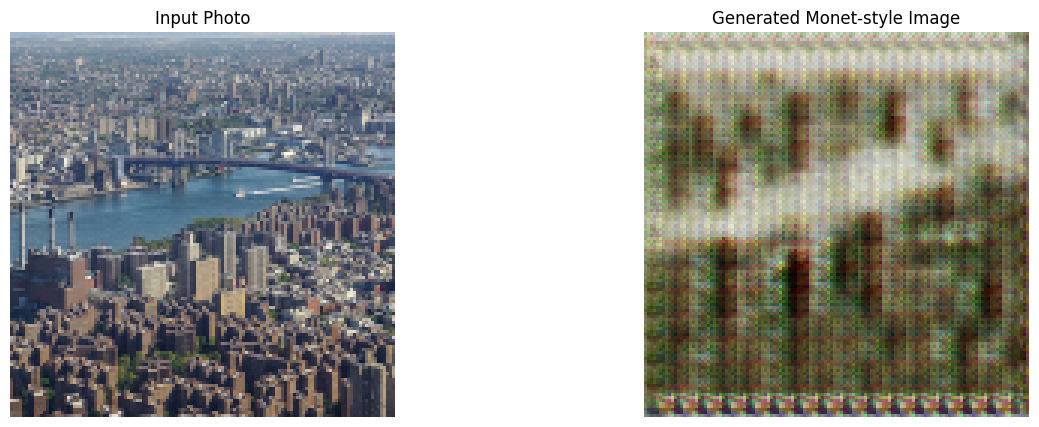

Step 2000/5630 - discriminator loss: 0.2522, generator loss: 0.2541

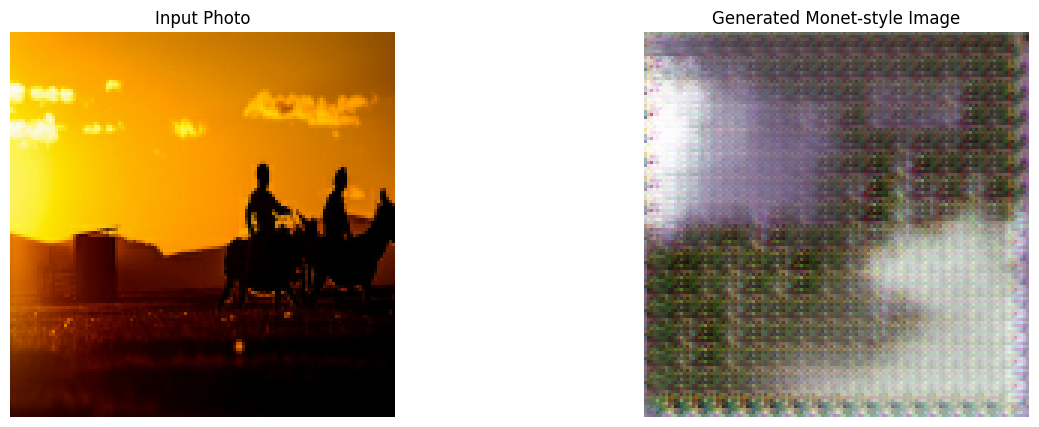

Step 3000/5630 - discriminator loss: 0.2523, generator loss: 0.2495

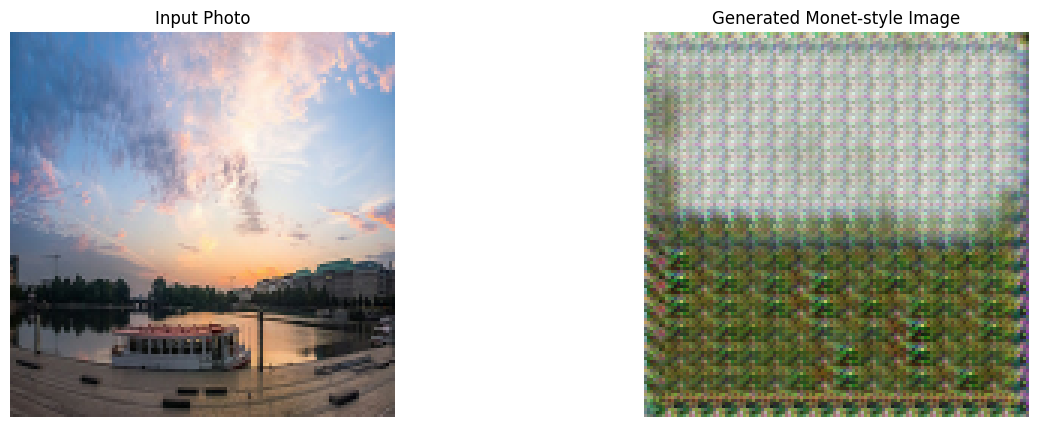

Step 4000/5630 - discriminator loss: 0.2519, generator loss: 0.2617

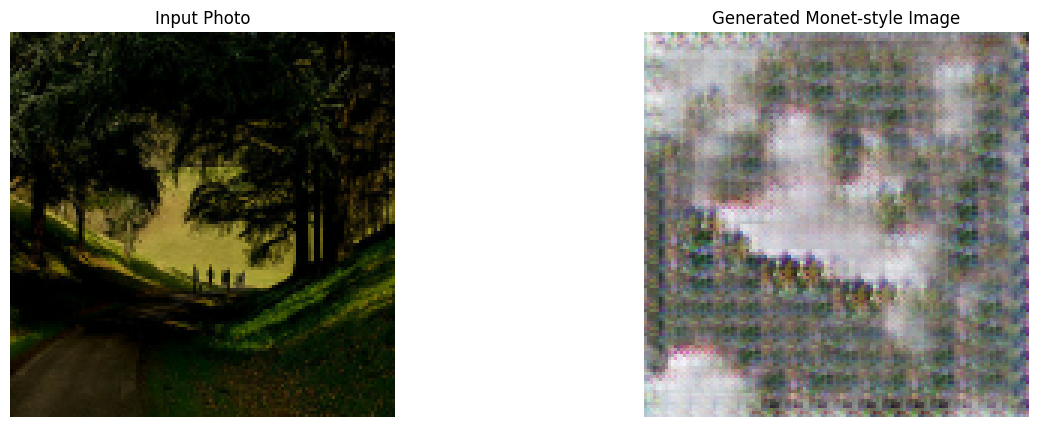

Step 5000/5630 - discriminator loss: 0.2511, generator loss: 0.2574

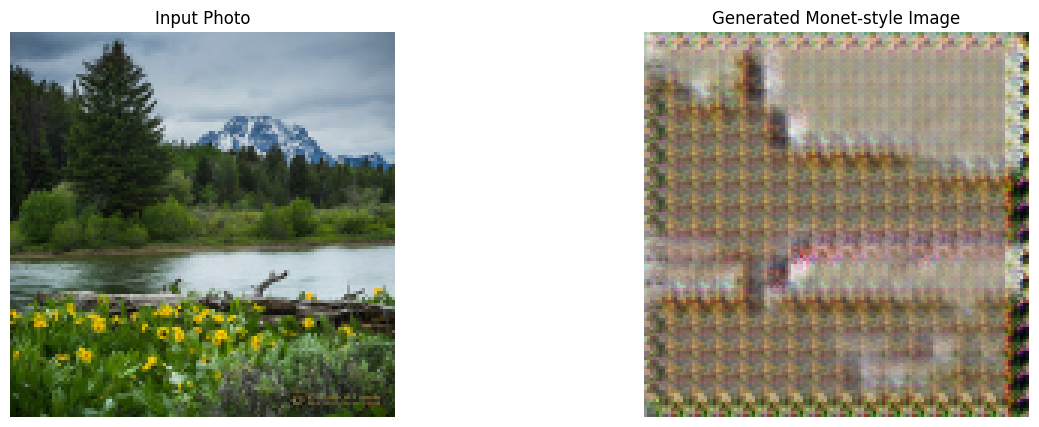

Step 5630/5630 - discriminator loss: 0.2521, generator loss: 0.2449
Epoch 3 completed in 2504s - avg discriminator loss: 0.2525, avg generator loss: 0.2507

Epoch 4/8


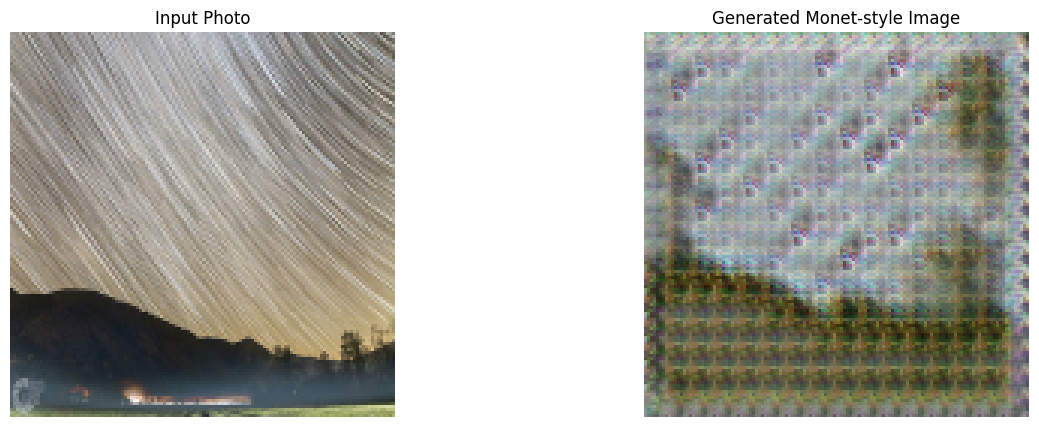

Step 1000/5630 - discriminator loss: 0.2503, generator loss: 0.2394

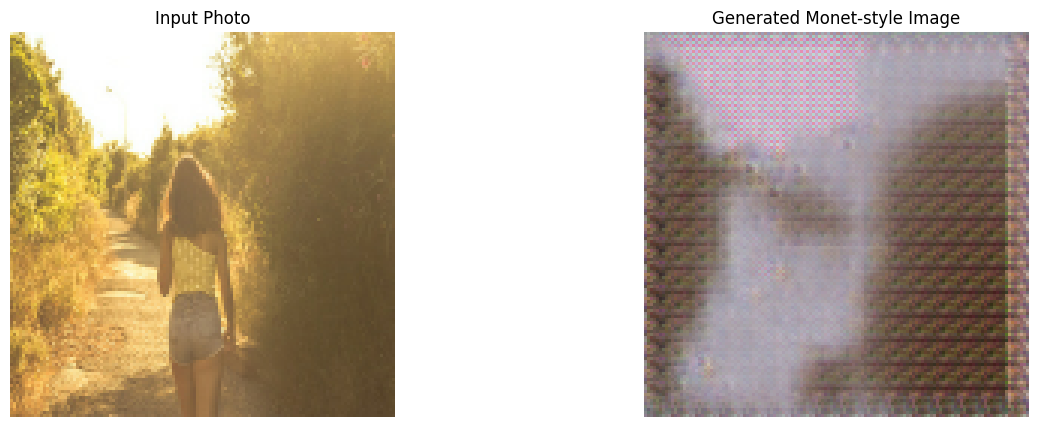

Step 2000/5630 - discriminator loss: 0.2518, generator loss: 0.2444

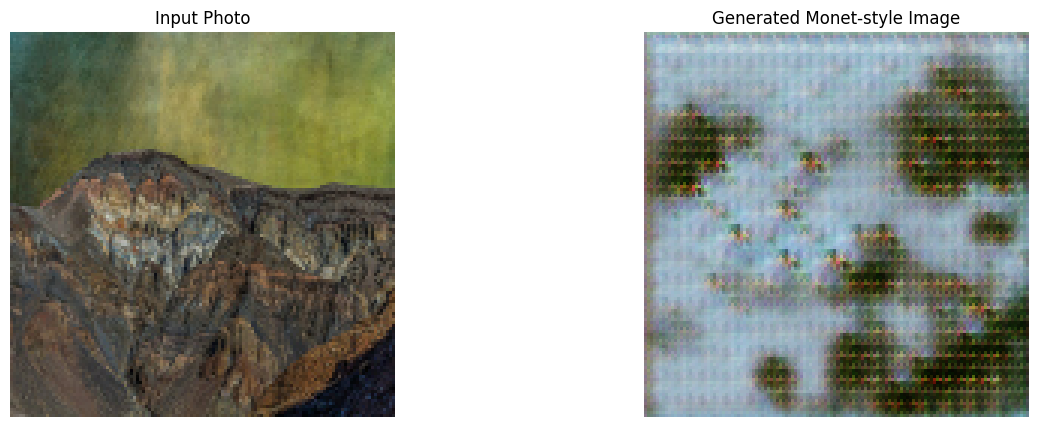

Step 2494/5630 - discriminator loss: 0.2514, generator loss: 0.2445

KeyboardInterrupt: 

In [33]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 8
EPOCH_LENGTH = DATASET_HEIGHT
DISPLAY_INTERVAL = 15  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)
gen_optimiser = Adam(beta_1=0.5)

my_generator = Generator((128, 128, 3), strides=2)
my_discriminator = build_discriminator()

eg_image = next(my_image_ds_train)
eg_output = my_generator(eg_image)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))
        # Display progress images every 100 steps

        if j % 1000 == 0:
            test_output = my_generator(real_image)
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(real_image[0] * 0.5 + 0.5)  # Denormalize
            plt.title('Input Photo')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(test_output[0] * 0.5 + 0.5)  # Denormalize
            plt.title('Generated Monet-style Image')
            plt.axis('off')
            plt.show()
            plt.close()



        with tf.GradientTape(persistent=True) as tape:
            real_monet = monet_image
            fake_monet = my_generator(real_image)

            real_monet_output = my_discriminator(real_monet)
            fake_monet_output = my_discriminator(fake_monet)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), real_monet_output) +
                my_square_loss(tf.constant(0.0), fake_monet_output)
            )

            monet_generator_loss = generator_loss(fake_monet_output)
        if j % 4 == 0 :
            grads = tape.gradient(loss, my_discriminator.trainable_variables)
            my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))
        else:
            generator_grads =  tape.gradient(monet_generator_loss, my_generator.trainable_variables)
            gen_optimiser.apply_gradients(zip(generator_grads, my_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            disc_loss = tf.squeeze(loss).numpy()
            gen_loss = tf.squeeze(monet_generator_loss).numpy()
            epoch_losses.append((disc_loss, gen_loss))
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - discriminator loss: {epoch_losses[-1][0]:.4f}, generator loss: {epoch_losses[-1][1]:.4f}", end='')

    epoch_avg_disc_loss = np.mean([l[0] for l in epoch_losses])
    epoch_avg_gen_loss = np.mean([l[1] for l in epoch_losses])
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg discriminator loss: {epoch_avg_disc_loss:.4f}, avg generator loss: {epoch_avg_gen_loss:.4f}")
    all_losses.extend(epoch_losses)


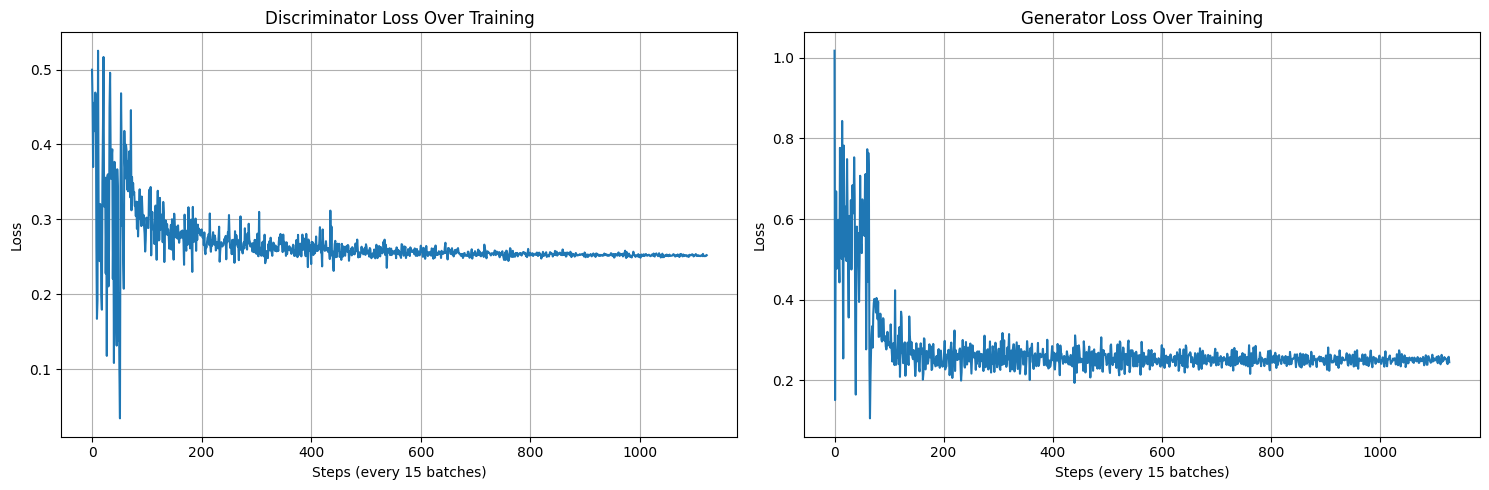

In [34]:

# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
disc_losses = [l[0] for l in all_losses]
plt.plot(disc_losses[5:])
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
gen_losses = [l[1] for l in all_losses]
plt.plot(gen_losses)
plt.title('Generator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

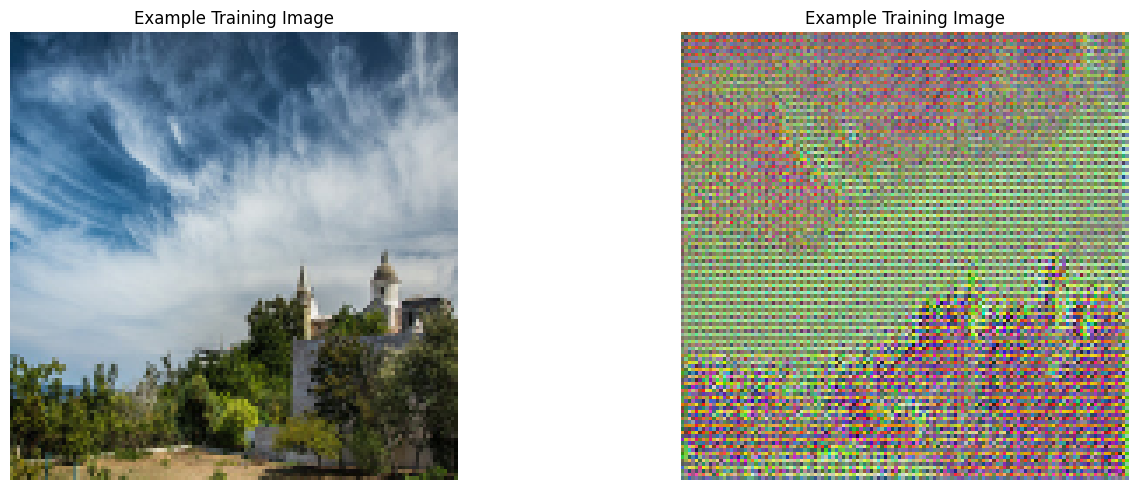

In [36]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(eg_image[0] * 0.5 + 0.5)  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(eg_output[0] * 0.5 + 0.5)  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


In [37]:
eg_output2 = my_generator(eg_image)

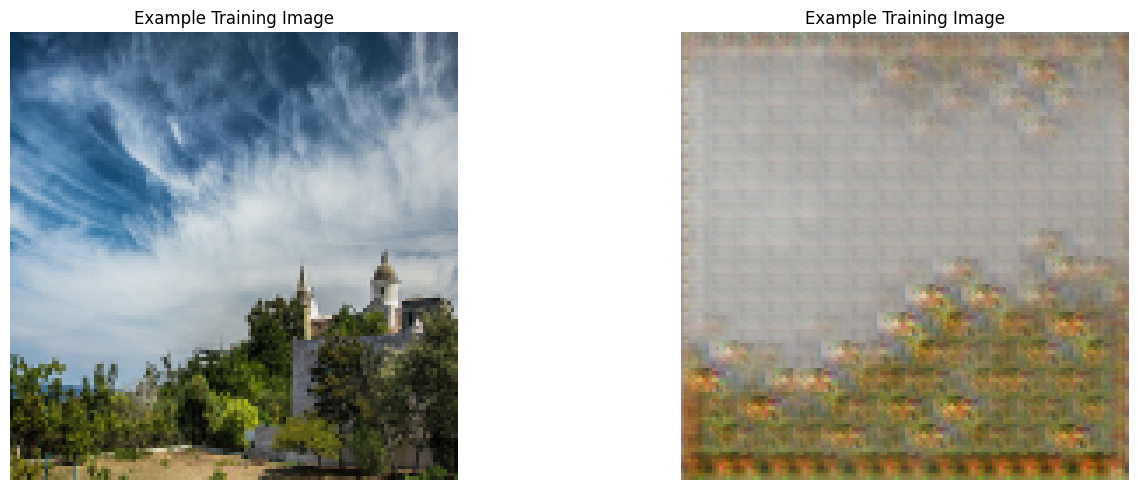

In [39]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(eg_image[0] * 0.5 + 0.5)  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(eg_output2[0] * 0.5 + 0.5)  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


In [ ]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 3
EPOCH_LENGTH = DATASET_HEIGHT // 3
DISPLAY_INTERVAL = 5  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

my_generator = Generator((128, 128, 3), strides=2)
my_discriminator = build_discriminator()

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))

        with tf.GradientTape() as tape:
            monet_output = my_discriminator(monet_image)
            image_output = my_discriminator(real_image)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), monet_output) +
                my_square_loss(tf.constant(0.0), image_output)
            )

        grads = tape.gradient(loss, my_discriminator.trainable_variables)
        my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            epoch_losses.append(tf.squeeze(loss).numpy())
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - loss: {epoch_losses[-1]:.4f}", end='')

    epoch_avg_loss = np.mean(epoch_losses)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg loss: {epoch_avg_loss:.4f}")
    all_losses.extend(epoch_losses)

# Plot full training loss curve
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()